# Zonal statistics

In [4]:
# Load raster
import rioxarray
burned = rioxarray.open_rasterio('burned.tif')
burned

<xarray.DataArray (band: 1, y: 4976, x: 4478)>
[22282528 values with dtype=int8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 5.65e+05 5.65e+05 5.65e+05 ... 6.098e+05 6.098e+05
  * y            (y) float64 4.04e+06 4.04e+06 4.04e+06 ... 3.99e+06 3.99e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [5]:
import geopandas as gpd
assets = gpd.read_file('assets.gpkg')
assets

,code,type,geometry
0,1,infrastructure,"POLYGON ((27.77240 35.89279, 27.77240 35.89280..."
1,2,built-up,"MULTIPOLYGON (((27.75075 35.87857, 27.75075 35..."


In [7]:
burned.rio.crs

CRS.from_epsg(32635)

In [8]:
assets.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [9]:
assets = assets.to_crs(burned.rio.crs)

# Rasterizing the vector data

In [10]:
geom = assets[['geometry', 'code']].values.tolist()
geom

[[<POLYGON ((569708.927 3972332.358, 569709.096 3972333.79, 569710.406 3972341...>,
  1],
 [<MULTIPOLYGON (((567767.095 3970740.732, 567767.548 3970741.604, 567772.083 ...>,
  2]]

In [14]:
burned.shape

(1, 4976, 4478)

In [16]:
# A squeeze is needed to make the raster 2D
# Since rasterize function only accept 2D shape
burned.squeeze().shape

(4976, 4478)

In [24]:
burned_squeeze = burned.squeeze()

In [25]:
from rasterio import features
assets_rasterized = features.rasterize(geom, out_shape=burned_squeeze.shape, transform=burned.rio.transform())

In [26]:
assets_rasterized

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [27]:
import numpy as np
print(assets_rasterized.shape)
print(np.unique(assets_rasterized))

(4976, 4478)
[0 1 2]


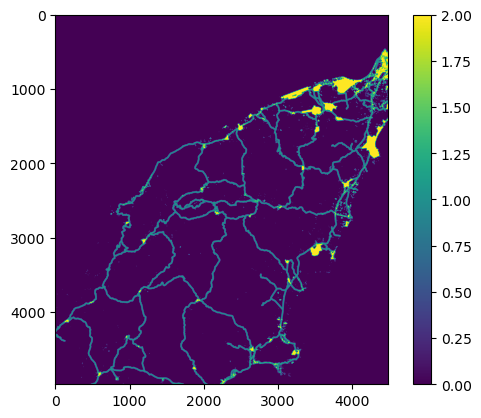

In [29]:
from matplotlib import pyplot as plt
plt.imshow(assets_rasterized)
plt.colorbar()

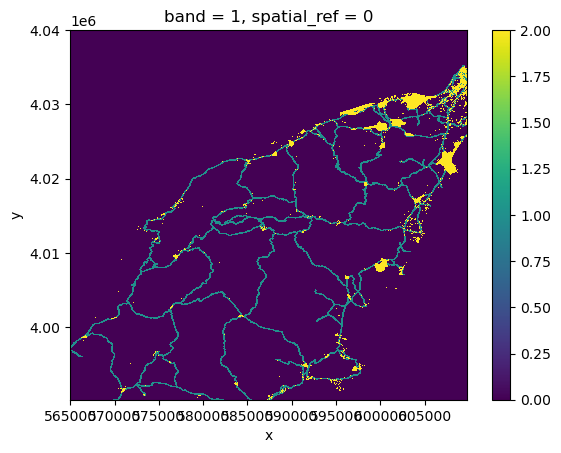

In [32]:
assets_rasterized_xarr = burned_squeeze.copy()
assets_rasterized_xarr.data = assets_rasterized

# visualize
assets_rasterized_xarr.plot()

In [34]:
from xrspatial import zonal_stats
stats = zonal_stats(assets_rasterized_xarr, burned_squeeze)

In [35]:
stats

,zone,mean,max,min,sum,std,var,count
0,0,0.023111,1.0,0.0,484224.0,0.150255,0.022576,20952490.0
1,1,0.011214,1.0,0.0,10560.0,0.105301,0.011088,941675.0
2,2,0.000003,1.0,0.0,1.0,0.001605,0.000003,388363.0
